In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import os
import unittest
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from vae import VAE
from score import ScoreNet
from networks import SimpleDecoder, SimpleEncoder

In [44]:
def make_swiss_roll(n_samples=100, *, noise=0.0, seed=None):
    generator = torch.Generator()
    generator.manual_seed(seed)
    t = 1.5 * np.pi * (1 + 2 * torch.rand(n_samples, generator=generator))
    x = t * torch.cos(t)
    y = t * torch.sin(t)

    X = torch.stack((x, y), dim=1)
    X += noise * torch.randn(n_samples, 2, generator=generator)
    return X, t

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

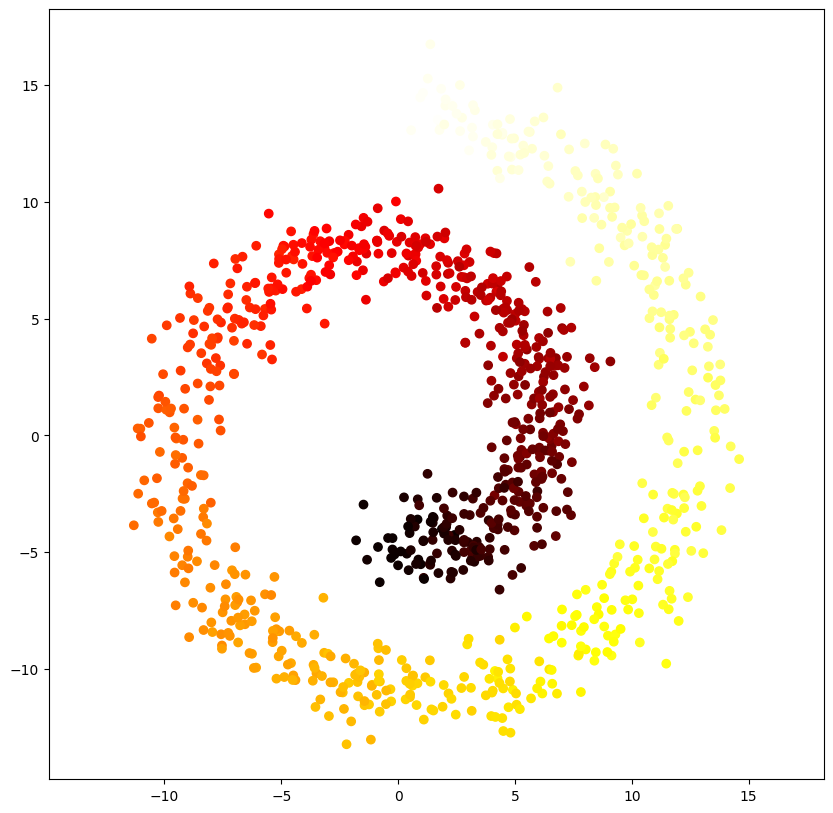

In [45]:
X, t = make_swiss_roll(n_samples=1000, noise=1., seed=42)
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis('equal')
plt.show()

In [46]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_vae_reparam')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.292s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [47]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_vae_loss')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.163s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [48]:
vae = VAE(
    SimpleEncoder(input_size=2, hidden_size=128, latent_size=10 * 2),
    SimpleDecoder(latent_size=10, hidden_size=128, output_size=2)
)
print(f'Number of parameters in VAE: {count_parameters(vae)}')
vae.train()

optimizer = optim.Adam(vae.parameters(), lr=1e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = vae.get_loss(X)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, loss {loss.item():.4f}')
print('Done!')

Number of parameters in VAE: 37654
Epoch 0, loss 51.7266
Epoch 200, loss 6.1238
Epoch 400, loss 4.7993
Epoch 600, loss 4.7117
Epoch 800, loss 4.7999
Epoch 1000, loss 4.7076
Epoch 1200, loss 4.6876
Epoch 1400, loss 4.7052
Epoch 1600, loss 4.6568
Epoch 1800, loss 4.6832
Done!


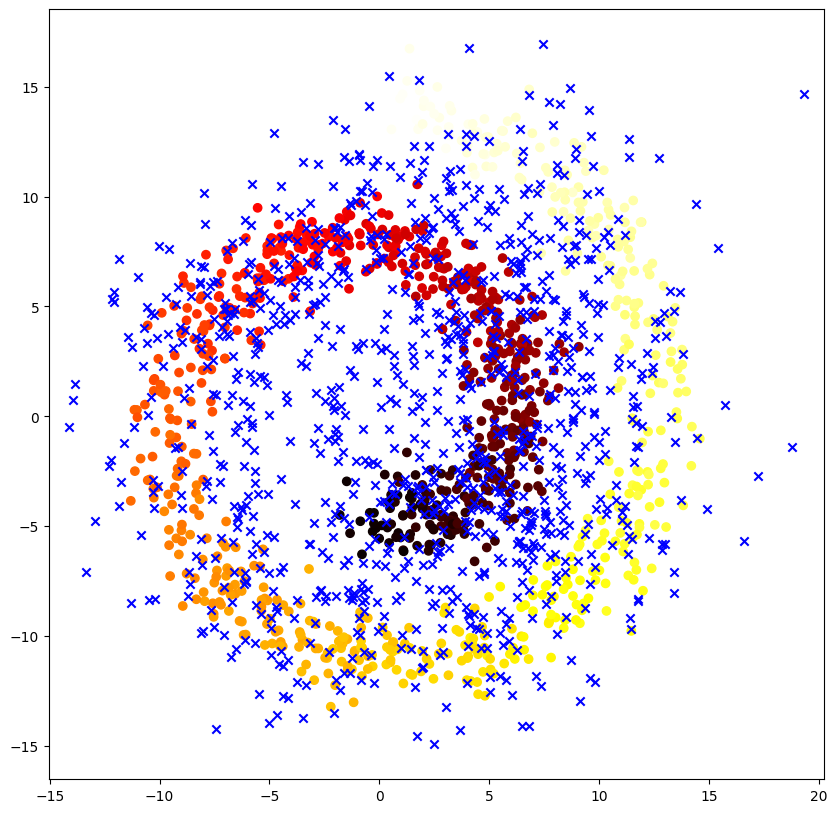

In [49]:
n_sample = 1000
vae.eval()
with torch.no_grad():
    X_gen = vae.sample(n_sample, 'cpu')
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.scatter(X_gen[:, 0], X_gen[:, 1], c='b', marker='x')
plt.axis('equal')
plt.show()

In [50]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_score_perturb')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.387s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [51]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_score_loss')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.326s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [52]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_score_sample')
unittest.TextTestRunner().run(suite)

.

sigmas: tensor([1.])
Processing sigma: 1.0
Step: 0



----------------------------------------------------------------------
Ran 1 test in 0.190s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [53]:
scorenet = ScoreNet(
    torch.nn.Sequential(
        SimpleEncoder(input_size=2, hidden_size=128, latent_size=16),
        SimpleDecoder(latent_size=16, hidden_size=128, output_size=2),
    ), 10., 0.1, 20, 'geometric'
)
scorenet.train()
optimizer = optim.Adam(scorenet.parameters(), lr=1e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = scorenet.get_loss(X)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, loss {loss.item():.4f}')
print('Done!')

Epoch 0, loss 0.5120
Epoch 200, loss 0.4297
Epoch 400, loss 0.4434
Epoch 600, loss 0.4400
Epoch 800, loss 0.4193
Epoch 1000, loss 0.4360
Epoch 1200, loss 0.4154
Epoch 1400, loss 0.3899
Epoch 1600, loss 0.4210
Epoch 1800, loss 0.4450
Done!


sigmas: tensor([10.0000,  7.8476,  6.1585,  4.8329,  3.7927,  2.9764,  2.3357,  1.8330,
         1.4384,  1.1288,  0.8859,  0.6952,  0.5456,  0.4281,  0.3360,  0.2637,
         0.2069,  0.1624,  0.1274,  0.1000])
Processing sigma: 10.0
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 7.847599506378174
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 6.158482074737549
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 4.832930088043213
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 3.7926902770996094
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 2.976351499557495
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 2.335721492767334
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Ste

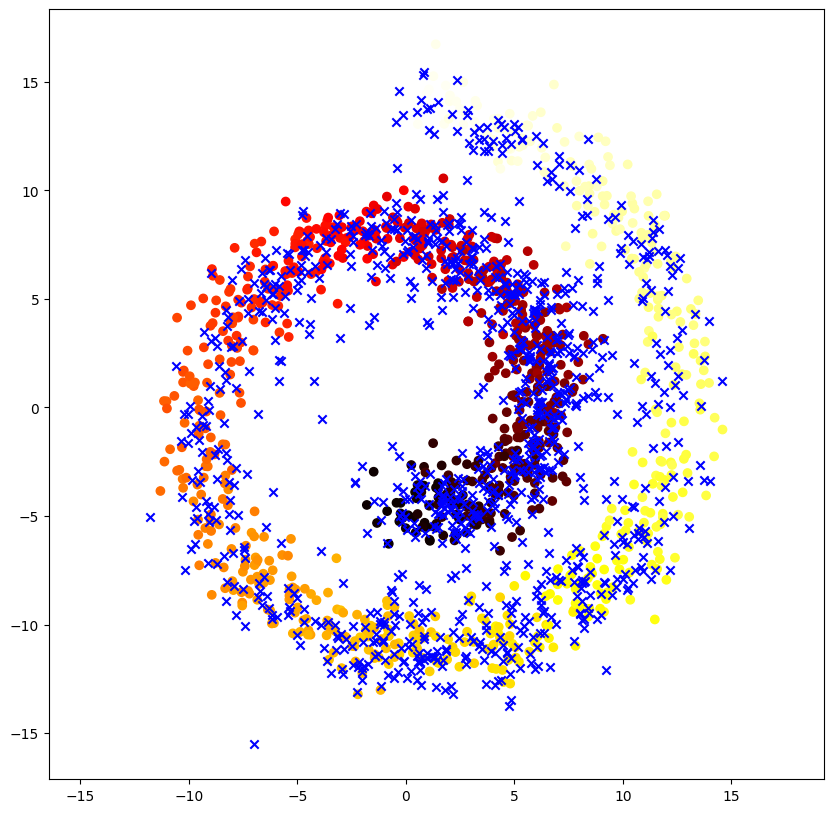

In [54]:
n_sample = 1000
scorenet.eval()
with torch.no_grad():
    X_gen = scorenet.sample(n_sample, 2, step_lr=2e-3)[-1, -1]
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.scatter(X_gen[:, 0], X_gen[:, 1], c='b', marker='x')
plt.axis('equal')
plt.show()

In [55]:
scorenet = ScoreNet(
    torch.nn.Sequential(
        SimpleEncoder(input_size=2, hidden_size=128, latent_size=16),
        SimpleDecoder(latent_size=16, hidden_size=128, output_size=2),
    ), 10., 0.1, 20, 'geometric'
)
scorenet.train()
optimizer = optim.Adam(scorenet.parameters(), lr=1e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = scorenet.get_loss(X)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, loss {loss.item():.4f}')
print('Done!')

Epoch 0, loss 0.4894
Epoch 200, loss 0.4352
Epoch 400, loss 0.4209
Epoch 600, loss 0.4250
Epoch 800, loss 0.4433
Epoch 1000, loss 0.4177
Epoch 1200, loss 0.4345
Epoch 1400, loss 0.4269
Epoch 1600, loss 0.4092
Epoch 1800, loss 0.4137
Done!


sigmas: tensor([10.0000,  7.8476,  6.1585,  4.8329,  3.7927,  2.9764,  2.3357,  1.8330,
         1.4384,  1.1288,  0.8859,  0.6952,  0.5456,  0.4281,  0.3360,  0.2637,
         0.2069,  0.1624,  0.1274,  0.1000])
Processing sigma: 10.0
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 7.847599506378174
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 6.158482074737549
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 4.832930088043213
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 3.7926902770996094
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 2.976351499557495
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 2.335721492767334
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Ste

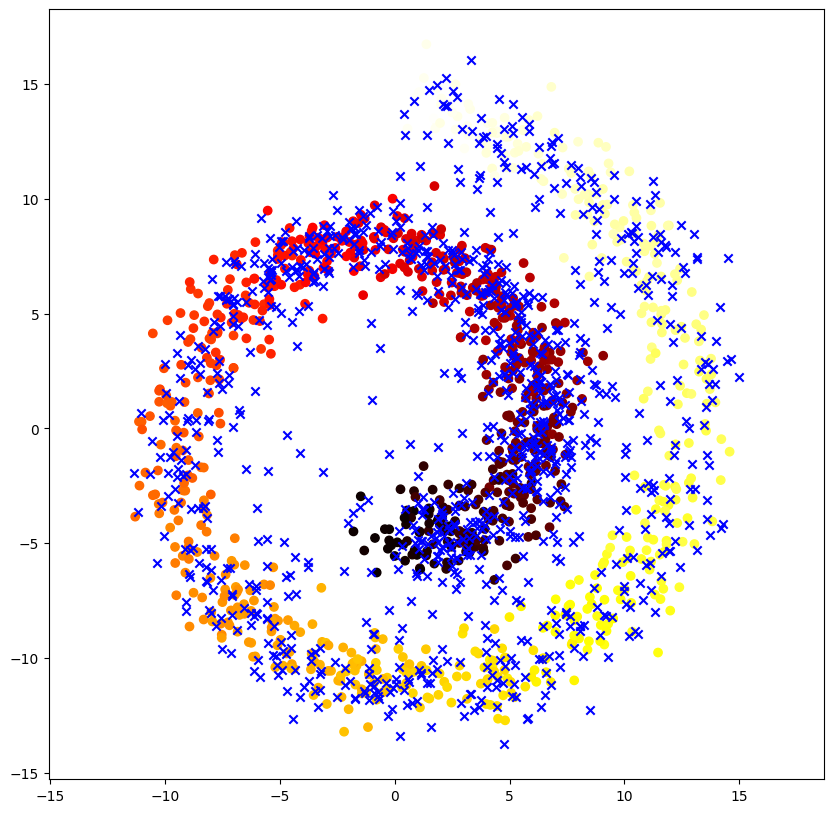

In [56]:
n_sample = 1000
scorenet.eval()
with torch.no_grad():
    X_gen = scorenet.sample(n_sample, 2, step_lr=2e-3)[-1, -1]
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.scatter(X_gen[:, 0], X_gen[:, 1], c='b', marker='x')
plt.axis('equal')
plt.show()

Epoch 0, loss 0.5029
Epoch 200, loss 0.4113
Epoch 400, loss 0.4308
Epoch 600, loss 0.4060
Epoch 800, loss 0.4228
Epoch 1000, loss 0.4070
Epoch 1200, loss 0.4146
Epoch 1400, loss 0.3910
Epoch 1600, loss 0.4137
Epoch 1800, loss 0.4102
Done!
sigmas: tensor([10.0000,  7.8476,  6.1585,  4.8329,  3.7927,  2.9764,  2.3357,  1.8330,
         1.4384,  1.1288,  0.8859,  0.6952,  0.5456,  0.4281,  0.3360,  0.2637,
         0.2069,  0.1624,  0.1274,  0.1000])
Processing sigma: 10.0
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 7.847599506378174
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 6.158482074737549
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 4.832930088043213
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 3.7926902770996094
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step

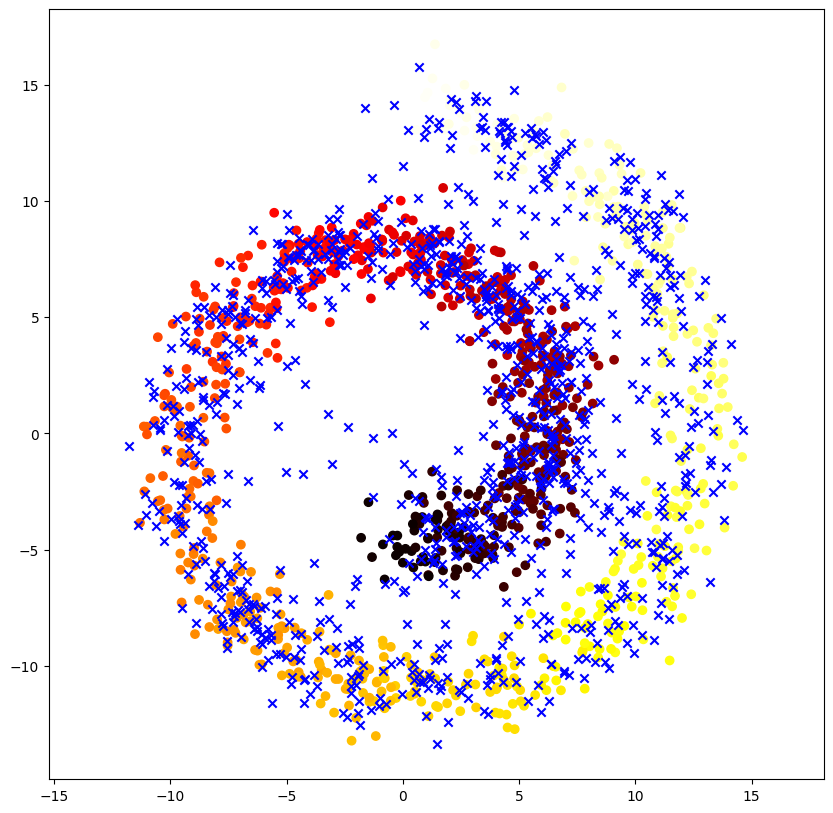

In [57]:
scorenet = ScoreNet(
    torch.nn.Sequential(
        SimpleEncoder(input_size=2, hidden_size=128, latent_size=16),
        SimpleDecoder(latent_size=16, hidden_size=128, output_size=2),
    ), 10., 0.1, 20, 'geometric'
)
scorenet.train()
optimizer = optim.Adam(scorenet.parameters(), lr=1e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = scorenet.get_loss(X)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, loss {loss.item():.4f}')
print('Done!')
n_sample = 1000
scorenet.eval()
with torch.no_grad():
    X_gen = scorenet.sample(n_sample, 2, step_lr=2e-3)[-1, -1]
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.scatter(X_gen[:, 0], X_gen[:, 1], c='b', marker='x')
plt.axis('equal')
plt.show()

Epoch 0, loss 0.4843
Epoch 200, loss 0.4216
Epoch 400, loss 0.3796
Epoch 600, loss 0.4070
Epoch 800, loss 0.4088
Epoch 1000, loss 0.4080
Epoch 1200, loss 0.3768
Epoch 1400, loss 0.4038
Epoch 1600, loss 0.4237
Epoch 1800, loss 0.3824
Done!
sigmas: tensor([10.0000,  7.8476,  6.1585,  4.8329,  3.7927,  2.9764,  2.3357,  1.8330,
         1.4384,  1.1288,  0.8859,  0.6952,  0.5456,  0.4281,  0.3360,  0.2637,
         0.2069,  0.1624,  0.1274,  0.1000])
Processing sigma: 10.0
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 7.847599506378174
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 6.158482074737549
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 4.832930088043213
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Processing sigma: 3.7926902770996094
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step

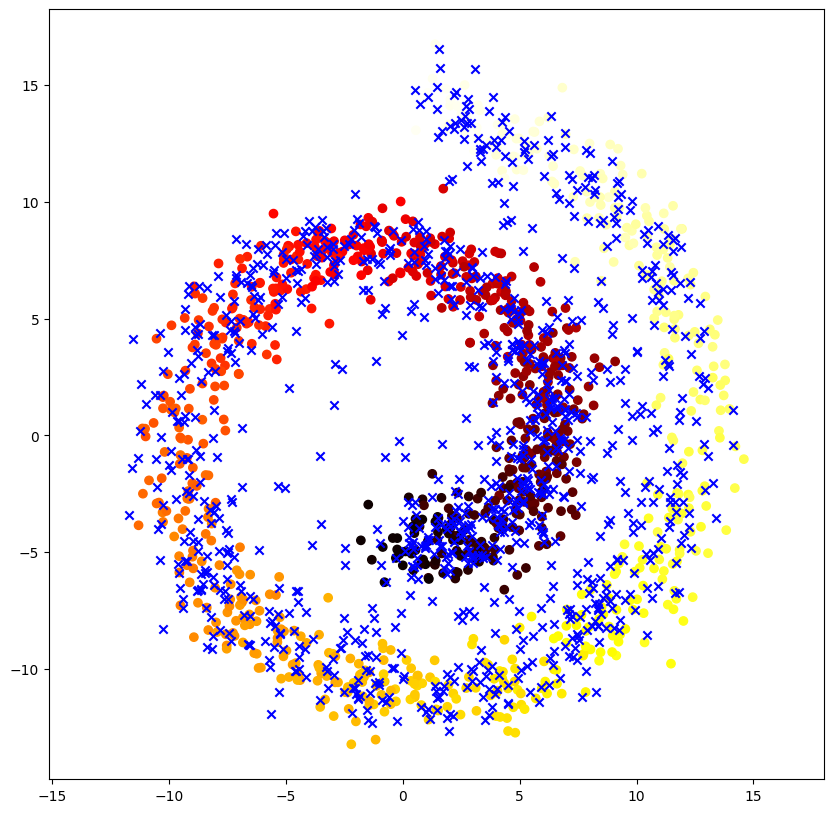

In [58]:
scorenet = ScoreNet(
    torch.nn.Sequential(
        SimpleEncoder(input_size=2, hidden_size=128, latent_size=16),
        SimpleDecoder(latent_size=16, hidden_size=128, output_size=2),
    ), 10., 0.1, 20, 'geometric'
)
scorenet.train()
optimizer = optim.Adam(scorenet.parameters(), lr=1e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = scorenet.get_loss(X)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, loss {loss.item():.4f}')
print('Done!')
n_sample = 1000
scorenet.eval()
with torch.no_grad():
    X_gen = scorenet.sample(n_sample, 2, step_lr=2e-3)[-1, -1]
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.scatter(X_gen[:, 0], X_gen[:, 1], c='b', marker='x')
plt.axis('equal')
plt.show()

In [59]:
CUDA_VISIBLE_DEVICES=1 

In [41]:
python train_mnist.py --num_epochs 30 --model_type simple_fc --output_dir runs/fc-v1

SyntaxError: invalid syntax (2514226885.py, line 1)